# Optimization of Scientific Code with Cython: Ising Model

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/) on the blog [Pythonic Perambulations](http://jakevdp.github.io).*

<!-- PELICAN_BEGIN_SUMMARY -->

Python is quick and easy to code, but can be slow when doing intensive numerical operations. Translating code to Cython can be helpful, but in most cases requires a bit of trial and error to achieve the optimal result. [Cython's tutorials](http://cython.readthedocs.io/en/latest/src/tutorial/) contain a lot of information, but for iterative workflows like optimization with Cython, it's often useful to see it done "live".

For that reason, I decided to record some screencasts showing this iterative optimization process, using an  [Ising Model](https://en.wikipedia.org/wiki/Ising_model), as an example application.

<!-- PELICAN_END_SUMMARY -->

## When to use Cython

Before I get to the videos, I wanted to say a few words about *when* and *why* you might choose Cython.

With scientific Python code, before turning to Cython I'd suggest going as far as you can with *vectorization*.
Vectorization involves the judicious use of built-in routines in NumPy, SciPy, Pandas, and other libraries to reduce the number of explicit for-loops in your code. It can work quite well in many situations, and doesn't require any sort of special compilation step in running your code. See my PyCon 2015 talk, [Losing Your Loops](https://www.youtube.com/watch?v=EEUXKG97YRw) for an intro to this approach.

When a problem cannot be easily solved using standard vectorization approaches, Cython is a good choice.
Cython provides a bridge between Python and C code, and is quite mature and reliable: it forms the basis of much of the PyData/Scientific Python ecosystem (for example, Cython is used heavily in NumPy, SciPy, Pandas, Scikit-Learn, and many other packages).

Other approaches to optimizing Python code are available, but I tend not to use them as often as Cython:

The [PyPy](https://pypy.org/) project is an alternative implementation of Python that avoids the slow loops of the default CPython implementation. Although it is quite promising, it currently does not support many of the core scientific packages, so is not the best choice for scientific code (though that has been changing).

[Numba](http://numba.pydata.org/) is a Python-to-LLVM converter which can often give you 100x speedups in Python by adding a simple compilation decorator to Python functions. For an example of Numba being used on code like that in this notebook, see [Matthew Rocklin's post](http://matthewrocklin.com/blog/work/2015/02/28/Ising). Though it is convenient, Numba doesn't support all Python constructs yet, and can be difficult to optimize when the most straightforward approach fails.

## The Code

Below you can find the code that I wrote in those two videos:

### 1. Simple Python Ising Model

#### Displaying an Ising Field

In [5]:
import numpy as np

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

random_spin_field(10, 10)

array([[-1,  1,  1,  1, -1,  1,  1,  1, -1,  1],
       [ 1,  1,  1,  1,  1, -1,  1, -1,  1,  1],
       [ 1,  1,  1,  1,  1, -1, -1,  1,  1, -1],
       [-1, -1,  1, -1,  1, -1, -1, -1,  1, -1],
       [-1,  1, -1, -1, -1,  1,  1,  1, -1,  1],
       [ 1,  1,  1, -1,  1, -1, -1,  1,  1, -1],
       [ 1, -1,  1, -1,  1, -1, -1, -1,  1,  1],
       [ 1,  1,  1, -1, -1,  1, -1,  1,  1,  1],
       [ 1,  1,  1,  1,  1, -1,  1, -1, -1, -1],
       [-1, -1, -1, -1, -1,  1,  1,  1, -1, -1]])

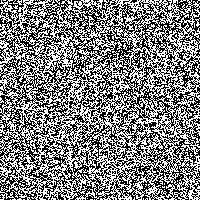

In [7]:
# pip install pillow
from PIL import Image

def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))  # 0 ... 255

display_spin_field(random_spin_field(200, 200))

#### Implementing the Ising Model

In [10]:
def ising_step(field, beta=0.5):
    N, M = field.shape
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _ising_update(field, n, m, beta)
    return field

def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape
    # Only 4 nearest neighbors (up, down, left, right)
    neighbors = [(n-1, m), (n+1, m), (n, m-1), (n, m+1)]
    for i, j in neighbors:
        total += field[i % N, j % M]
    dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n, m] *= -1


#### Animating an Ising Sequence

Note that this requires a live kernel, and so will not show up on the blog or other static rendering:

In [13]:
from ipywidgets import interact

def display_ising_sequence(images):
    def _show(frame=(0, len(images) - 1)):
        return display_spin_field(images[frame])
    return interact(_show)

In [16]:
images = [random_spin_field(200, 200)]
for i in range(100):
    images.append(ising_step(images[-1].copy()))
display_ising_sequence(images);

KeyboardInterrupt: 

### 2. Use Cython to speed it up

In [15]:
pip install Cython

Note: you may need to restart the kernel to use updated packages.


In [16]:
%load_ext Cython

In [17]:
%%cython

cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_step(np.int64_t[:, :] field, float beta=0.4):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _cy_ising_update(field, n, m, beta, N, M)
    return np.array(field)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cy_ising_update(np.int64_t[:, :] field, int n, int m, float beta, int N, int M):
    cdef int total = 0
    # Directly compute indices for 4 orthogonal neighbors with periodic boundaries
    total += field[(n-1) % N, m]     # Up
    total += field[(n+1) % N, m]     # Down
    total += field[n, (m-1) % M]     # Left
    total += field[n, (m+1) % M]     # Right
    
    cdef float dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n, m] *= -1

#### Timing the result

In [23]:
field = random_spin_field(200, 200)
%timeit ising_step(field)
%timeit cy_ising_step(field)

141 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
851 μs ± 3.62 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Visualizing the result

(Note that the following code requires a live kernel, and will not display within a static rendering such as the blog post):

In [34]:
images = [random_spin_field(500, 500)]
for i in range(500):
    images.append(cy_ising_step(images[-1].copy(), beta=0.50))
display_ising_sequence(images);

interactive(children=(IntSlider(value=250, description='frame', max=500), Output()), _dom_classes=('widget-int…

In [ ]:
images = [random_spin_field(500, 500)]
for i in range(5000):
    images.append(cy_ising_step(images[-1].copy(), beta=0.41))
display_ising_sequence(images);

In [30]:
images = [random_spin_field(500, 500)]
for i in range(500):
    images.append(cy_ising_step(images[-1].copy(), beta=0.38))
display_ising_sequence(images);

interactive(children=(IntSlider(value=250, description='frame', max=500), Output()), _dom_classes=('widget-int…

# Transition Temperature

In [39]:
def magnetization(field):
    """|magnetisation| per spin (same as ⟨|m|⟩)."""
    return abs(field.sum()) / field.size

# Revised simulation parameters
L = 64  # Larger system reduces finite-size effects
thermalization_steps = 3000  # Increased equilibration
measurement_steps = 5000  # More measurements for better averaging
temperatures = np.linspace(1.0, 3.5, 25)  # Focus near Tc
betas = 1.0 / temperatures

# Store results
avg_magnetizations = []

# Run simulations
for i, beta in enumerate(betas):
    T = 1/beta
    print(f"Running T = {T:.3f} ({i+1}/{len(betas)})")
    
    field = random_spin_field(L, L)
    
    # Thermalization with progress monitoring
    for step in range(thermalization_steps):
        ising_step(field, beta)
        if step % 500 == 0:
            mag = magnetization(field)
            print(f"  Step {step}: M = {mag:.3f}", end='\r')
    
    # Measurement with improved averaging
    mag_sum = 0.0
    for step in range(measurement_steps):
        ising_step(field, beta)
        mag_sum += magnetization(field)
        if step % 1000 == 0:
            print(f"  Measurement {step}: Current avg M = {mag_sum/(step+1):.4f}", end='\r')
    
    avg_mag = mag_sum / measurement_steps
    avg_magnetizations.append(avg_mag)
    print(f"  T = {T:.3f} Final M = {avg_mag:.4f}")



Running T = 1.000 (1/25)
  T = 1.000 Final M = 0.9993avg M = 0.9993
Running T = 1.104 (2/25)
  T = 1.104 Final M = 0.9984avg M = 0.9984
Running T = 1.208 (3/25)
  T = 1.208 Final M = 0.9968avg M = 0.9968
Running T = 1.312 (4/25)
  T = 1.312 Final M = 0.9944avg M = 0.9944
Running T = 1.417 (5/25)
  T = 1.417 Final M = 0.9906avg M = 0.9906
Running T = 1.521 (6/25)
  T = 1.521 Final M = 0.9853avg M = 0.9852
Running T = 1.625 (7/25)
  T = 1.625 Final M = 0.9776avg M = 0.9777
Running T = 1.729 (8/25)
  T = 1.729 Final M = 0.9667avg M = 0.9667
Running T = 1.833 (9/25)
  T = 1.833 Final M = 0.9513avg M = 0.9513
Running T = 1.938 (10/25)
  T = 1.938 Final M = 0.9293avg M = 0.9295
Running T = 2.042 (11/25)
  T = 2.042 Final M = 0.8960avg M = 0.8967
Running T = 2.146 (12/25)
  T = 2.146 Final M = 0.8383avg M = 0.8390
Running T = 2.250 (13/25)
  T = 2.250 Final M = 0.6633avg M = 0.6536
Running T = 2.354 (14/25)
  T = 2.354 Final M = 0.2098avg M = 0.2157
Running T = 2.458 (15/25)
  T = 2.458 Final

NameError: name 'temperatures' is not defined

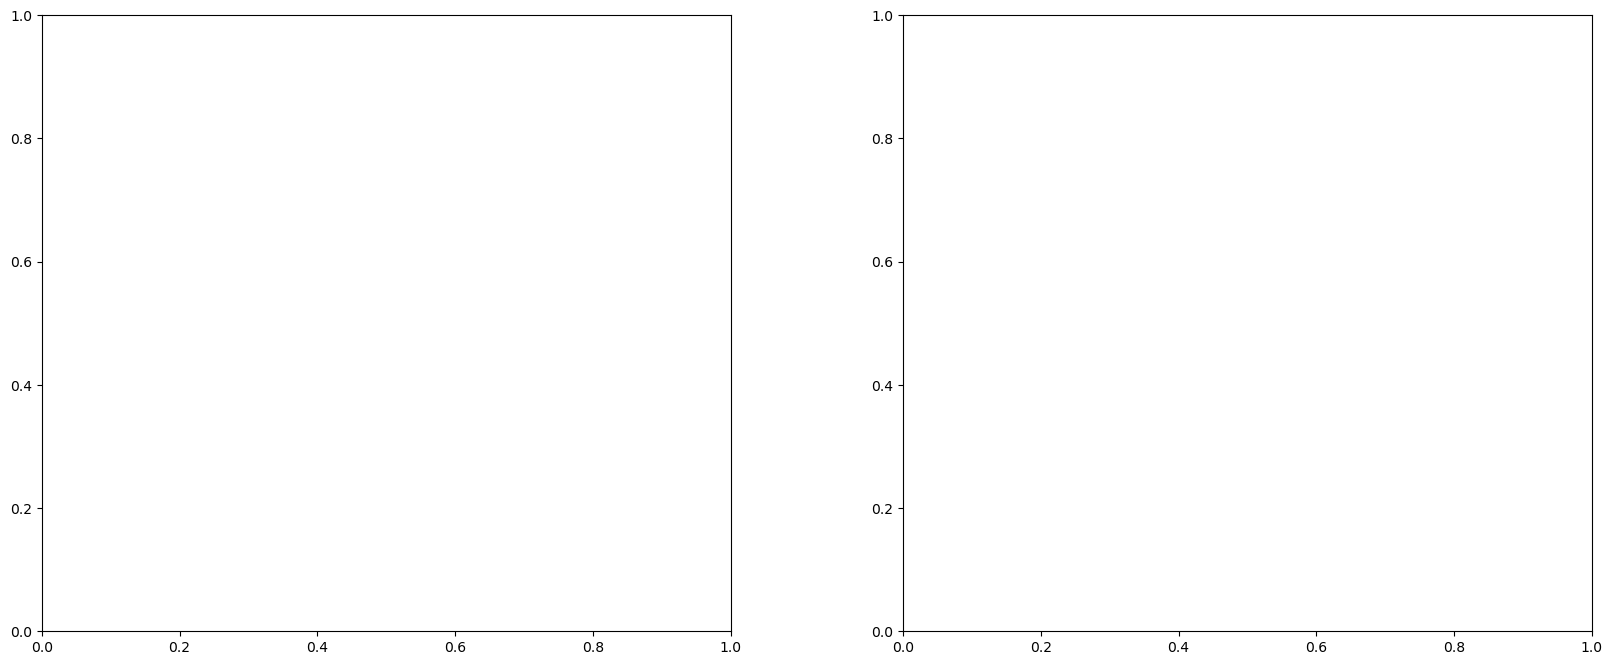

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormaps
cmap1 = LinearSegmentedColormap.from_list('phase_cmap', ['#1f77b4', '#ff7f0e'])
cmap2 = LinearSegmentedColormap.from_list('inverse_cmap', ['#2ca02c', '#d62728'])

# =================================================================
# Create figure with subplots
# =================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=100)
plt.subplots_adjust(wspace=0.25)

# =================================================================
# Plot 1: Magnetization vs Temperature (Simulation Units)
# =================================================================
# Create color gradient along the curve
colors1 = cmap1(np.linspace(0, 1, len(temperatures)))
for i in range(1, len(temperatures)):
    ax1.plot(temperatures[i-1:i+1], avg_magnetizations[i-1:i+1], 
             color=colors1[i], lw=2.5, alpha=0.9)

# Add theoretical Tc line
ax1.axvline(x=2.269, color='#d62728', linestyle='--', lw=2.5, 
            alpha=0.9, label='Theoretical $T_c$ = 2.269 $J/k_B$')

# Highlight phases
ax1.axvspan(min(temperatures), 2.269, alpha=0.08, color='#1f77b4', label='Ordered Phase')
ax1.axvspan(2.269, max(temperatures), alpha=0.08, color='#ff7f0e', label='Disordered Phase')

# Format plot
ax1.set_title('Phase Transition in 2D Ising Model', fontsize=18, pad=15)
ax1.set_xlabel('Temperature ($J/k_B$)', fontsize=14)
ax1.set_ylabel(r'Average Magnetization $\langle |M| \rangle$', fontsize=14)
ax1.grid(True, alpha=0.2)

# Add colorbar
sm1 = plt.cm.ScalarMappable(cmap=cmap1, 
                          norm=plt.Normalize(vmin=min(temperatures), 
                                       vmax=max(temperatures)))
sm1.set_array([])
cbar1 = fig.colorbar(sm1, ax=ax1, orientation='vertical')
cbar1.set_label('Temperature ($J/k_B$)', fontsize=12)
cbar1.outline.set_visible(False)

# Add annotations
ax1.annotate('Cubic Phase', xy=(1.6, 0.85), fontsize=14, ha='center', 
             bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='#1f77b4', alpha=0.8))
ax1.annotate('Tetragonal Phase', xy=(3.0, 0.15), fontsize=14, ha='center', 
             bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='#ff7f0e', alpha=0.8))

# =================================================================
# Plot 2: Magnetization vs Inverse Temperature
# =================================================================
inverse_temps = 1/temperatures
colors2 = cmap2(np.linspace(0, 1, len(inverse_temps)))
for i in range(1, len(inverse_temps)):
    ax2.plot(inverse_temps[i-1:i+1], avg_magnetizations[i-1:i+1], 
             color=colors2[i], lw=2.5, alpha=0.9)

# Add theoretical Tc line (1/2.269 ≈ 0.4407)
ax2.axvline(x=1/2.269, color='#d62728', linestyle='--', lw=2.5, 
            alpha=0.9, label='Theoretical $1/T_c$ = 0.441')

# Format plot
ax2.set_title('Magnetization vs Inverse Temperature', fontsize=18, pad=15)
ax2.set_xlabel('Inverse Temperature ($k_B/J$)', fontsize=14)
ax2.set_ylabel(r'Average Magnetization $\langle |M| \rangle$', fontsize=14)
ax2.grid(True, alpha=0.2)

# Add colorbar
sm2 = plt.cm.ScalarMappable(cmap=cmap2, 
                          norm=plt.Normalize(vmin=min(inverse_temps), 
                                       vmax=max(inverse_temps)))
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical')
cbar2.set_label('Inverse Temperature ($k_B/J$)', fontsize=12)
cbar2.outline.set_visible(False)

# Add annotation for critical region
ax2.annotate('Critical Region', xy=(0.44, 0.5), fontsize=14, ha='center', 
             rotation=90, bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='#d62728', alpha=0.8))

# =================================================================
# Final formatting
# =================================================================
plt.suptitle(r'Phase Transition in 2D Ising Model: $\langle |M| \rangle = \frac{1}{N}\left|\sum_{i} s_i\right|$', 
             fontsize=20, y=1.02)
plt.savefig('ising_phase_transition.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# =================================================================
# Step 1: Calculate J from experimental Tc
# =================================================================
T_c_sim = 2.269  # Simulation critical temperature (dimensionless)
T_c_real = 393   # Experimental critical temperature (Kelvin)

# Calculate exchange coupling J
k_B = 8.617333e-5  # Boltzmann constant in eV/K
J = k_B * T_c_real / T_c_sim  # Exchange coupling in eV

print(f"Calculated exchange coupling J = {J:.6f} eV")
print(f"J in meV = {J*1000:.3f} meV")

# =================================================================
# Step 2: Set up real temperature simulations
# =================================================================
# Real temperature range (Kelvin)
real_temperatures = np.linspace(100, 700, 25)  # From 100K to 700K

# Convert to simulation temperatures
sim_temperatures = real_temperatures * (T_c_sim / T_c_real)
sim_betas = 1.0 / sim_temperatures

# =================================================================
# Step 3: Run simulations at real temperatures
# =================================================================
thermalization_steps = 10000
measurement_steps = 10000
L = 64  # or larger (128) if possible

real_avg_magnetizations = []

print("\nStarting simulations at real temperatures:")
for i, beta in enumerate(sim_betas):
    T_real = real_temperatures[i]
    print(f"\nRunning T_real = {T_real:.1f} K ({i+1}/{len(sim_betas)})")
    print(f"  Corresponding T_sim = {1/beta:.4f}")
    
    # Initialize random spin field
    field = random_spin_field(L, L)
    
    # Thermalization
    print("  Thermalizing...", end=' ')
    for step in range(thermalization_steps):
        ising_step(field, beta)
    print("Done")
    
    # Acceptance ratio check (optional but strongly recommended)
    accepted = 0
    total_attempts = L*L*100
    for step in range(100):
        for _ in range(L*L):
            x, y = np.random.randint(0, L, 2)
            dE = 2 * field[x,y] * (
                field[(x+1)%L,y] + field[x,(y+1)%L] +
                field[(x-1)%L,y] + field[x,(y-1)%L])
            if dE <= 0 or np.exp(-dE * beta) > np.random.rand():
                field[x,y] *= -1
                accepted += 1
    acceptance_ratio = accepted / total_attempts
    print(f"  Acceptance ratio: {acceptance_ratio:.3f}")
    
    # Measurement
    mag_sum = 0.0
    print("  Measuring...", end=' ')
    for step in range(measurement_steps):
        ising_step(field, beta)
        mag_sum += magnetization(field)
    print("Done")
    
    avg_mag = mag_sum / measurement_steps
    real_avg_magnetizations.append(avg_mag)
    print(f"  Average magnetization = {avg_mag:.4f}")


In [ ]:
print(f"J = {J*1000:.3f} meV")
print(f"T_c = {T_c_real} K")


# =================================================================
# Step 4: Magnetization vs Temperature (Real Temperature Scale)
# =================================================================
plt.figure(figsize=(12, 8))

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(real_temperatures)))

for i in range(1, len(real_temperatures)):
    plt.plot(real_temperatures[i-1:i+1], real_avg_magnetizations[i-1:i+1], 
             color=colors[i], lw=3, alpha=0.9)

# Critical temperature line
plt.axvline(x=T_c_real, color='#d62728', linestyle='--', lw=3, alpha=0.9)

# Phases highlighted
plt.axvspan(min(real_temperatures), T_c_real, alpha=0.08, color='#1f77b4')
plt.axvspan(T_c_real, max(real_temperatures), alpha=0.08, color='#ff7f0e')

# Basic plot labels
plt.title('Cubic-Tetragonal Phase Transition in BaTiO3', fontsize=18)
plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel(r'Average Magnetization $\langle |M| \rangle$', fontsize=14)
plt.grid(True, alpha=0.2)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=min(real_temperatures), 
                                              vmax=max(real_temperatures)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Temperature (K)', fontsize=12)
cbar.outline.set_visible(False)

# Text box showing values of J and Tc
textstr = f'$J = {J*1000:.3f}$ meV\n$T_c = {T_c_real}$ K'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

plt.tight_layout()
plt.savefig('perovskite_phase_transition_real_T.png', dpi=300, bbox_inches='tight')
plt.show()

# =================================================================
# Step 5: Magnetization vs Inverse Temperature (Simplified)
# =================================================================
plt.figure(figsize=(12, 8))

inv_temperatures = 1 / real_temperatures
cmap2 = plt.get_cmap('plasma')
colors2 = cmap2(np.linspace(0, 1, len(inv_temperatures)))

for i in range(1, len(inv_temperatures)):
    plt.plot(inv_temperatures[i-1:i+1], real_avg_magnetizations[i-1:i+1], 
             color=colors2[i], lw=3, alpha=0.9)

# Critical inverse temperature line
inv_Tc = 1 / T_c_real
plt.axvline(x=inv_Tc, color='#d62728', linestyle='--', lw=3, alpha=0.9)

# Basic plot labels
plt.title('Order Parameter vs Inverse Temperature', fontsize=18)
plt.xlabel('Inverse Temperature (1/K)', fontsize=14)
plt.ylabel(r'Average Magnetization $\langle |M| \rangle$', fontsize=14)
plt.grid(True, alpha=0.2)

# Colorbar
sm2 = plt.cm.ScalarMappable(cmap=cmap2, 
                            norm=plt.Normalize(vmin=min(inv_temperatures), 
                                               vmax=max(inv_temperatures)))
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=plt.gca())
cbar2.set_label('Inverse Temperature (1/K)', fontsize=12)
cbar2.outline.set_visible(False)

# Annotation for critical region (without label)
plt.annotate('Critical Region', xy=(inv_Tc+0.0001, 0.5), fontsize=14, ha='left', va='center',
             rotation=90, bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='#d62728', alpha=0.8))


plt.tight_layout()
plt.savefig('perovskite_order_parameter_inverse_T.png', dpi=300, bbox_inches='tight')
plt.show()